# Data Science Project | Group A

### NAPLAN Numeracy results in Australian High Schools: Can we predict results and determine the most influential features?

## Project Outline:
- Problem Statement & Data Sources
- Data Preparation
- Data Exploration & Initial Analysis
- Modelling:
    - Linear Regression
    - Gaussian NB
    - Multinomial NB
- Conclusion/Results
- Further Improvements

## Problem Statement
Can we predict NAPLAN results and determine the most influential features?

## Data Sources
NAPLAN (National Assessment Program - Literacy and Numeracy) is an assesment taken by all Australian school children in years 3, 5, 7, 9 which provides parents an indication of how their child is progressing at school. The data obtained from the assesments drives improvements at a state and national level. The following is an analysis of the NAPLAN Numeracy Data combined with financial data and school statistics. We will analyse these combined results while also modelling and identifying the different fators that allow some students to get ahead while leaving other students behind.

Due to time and resource constraints, we are only analysing Year9 Numeracy Results.

We applied for this data from ASCAR (Australian Curriculum Assessment and Reporting Authority). Among the various datasets they provided us we analysed:
- NAPLAN results for 2017
- Funding for the previous year (2016)

We then combined these two data sets with the publically available schools data found [HERE](https://www.acara.edu.au/contact-us/acara-data-access).

## Data Preparation
The below libraries and utilities were used in this analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import KBinsDiscretizer

We will first import the three data sets then feed them into our utils to merge the data into one complete DataFrame

In [2]:
funding2016 = pd.read_excel("data/funding2016.xlsx")
naplan2017 = pd.read_excel("data/naplan2017.xlsx")
schools = pd.read_csv("data/schools.txt")

In [3]:
#declare an empty dataframe
df = pd.DataFrame()

#initialise the dataframe with Australian Schools data
df = utils.initialise_df(schools) 

#get funding data and add to dataframe
df = utils.get_funding(df, funding2016) 

#get NAPLAN restuls for 2017 and add to dataframe
df = utils.get_results(df, naplan2017)



Now that we have our DataFrame, we will make a copy for the Naive Bayes analysis in the second half of the project. 

In [4]:
#Copy of the data set for Naive Bayes in second half
df2 = df.copy()

df.head()

,state,sector,grades,geolocation,icsea,staff,numStudents,staff_per_student,indigenous_percent,non_english_home_percent,boys_percent,Aus_funding,state_funding,parent_funding,other_funding,gross_funding,gross_per_student,net_per_student,naplan
40001,TAS,Independent,Combined,Inner Regional,1130.0,33.3,372.0,0.089516,1.0,7.0,0.000000,2045885.0,652459.0,4459893.0,196090.0,7354327.0,19877.0,18056.0,614.0
40002,TAS,Independent,Combined,Outer Regional,969.0,14.5,194.0,0.074742,8.0,4.0,59.793814,1891542.0,572070.0,357110.0,41357.0,2862079.0,15918.0,14189.0,565.0
40005,TAS,Independent,Combined,Inner Regional,1053.0,9.1,100.0,0.091000,0.0,0.0,54.000000,883228.0,169504.0,311991.0,29318.0,1394041.0,12968.0,12968.0,631.0
40007,TAS,Independent,Combined,Inner Regional,1108.0,76.4,743.0,0.102826,2.0,7.0,51.816958,5637449.0,1803270.0,9162105.0,496490.0,17099314.0,23716.0,20725.0,605.0
40008,TAS,Catholic,Combined,Outer Regional,897.0,22.1,239.0,0.092469,36.0,0.0,56.903766,3112308.0,782272.0,371979.0,60463.0,4327022.0,19231.0,17451.0,559.0


Our data has sucessfully been imported and merged into one dataframe. Next we will check for any missing, incomplete or unusual data. 

What is the shape of the data?

In [5]:
print(df.shape)

(2393, 19)


We have 2393 rows which means 2393 schools. This is smaller than you'd expect but remember, we are only looking at Year 9 results in Numeracy (so all primary shools are excluded). Next check data types:

In [6]:
df.dtypes

state                        object
sector                       object
grades                       object
geolocation                  object
icsea                       float64
staff                       float64
numStudents                 float64
staff_per_student           float64
indigenous_percent          float64
non_english_home_percent    float64
boys_percent                float64
Aus_funding                 float64
state_funding               float64
parent_funding              float64
other_funding               float64
gross_funding               float64
gross_per_student           float64
net_per_student             float64
naplan                      float64
dtype: object

The majority of our features are floats. Below we will split them into **numerical** and **categorical** feature lists and describe them:

In [7]:
numerical_features = list(df.select_dtypes(include=[np.number]).columns.values)
categorical_features = ['state', 'sector', 'grades', 'geolocation']

Feature  | Description
-------- | -------------
**state**|The state the school is in
**sector**|Independant, Catholic or Government
**grades**| Primary, Secondary or combined
**geolocation**|where the school is located geographically
**icsea**| Index of Community Socio-Educational Advantage
**staff**|number of staff at school
**numStudents**| number of students at school
**staff_per_student**|number staff divided by number students
**indigenous_percent**|percentage of students who are Indigenous Australians
**non_english_percent**|percentage of students who speak a language other than English at home
**boys_percent**|percentage of students who are male
**Aus_funding**|Funding received from Australian Government
**state_funding**|Funding received from State Government
**parent_funding**|Funding received from parents
**other_funding**|Funding received from other private sources
**gross_funding**|Sum of the above funding
**gross_per_student**| gross divided by numStudents
**net_per_student**|Gross minus school costs divided by numStudents
**naplan**|Average Naplan Result in Yr9 Numeracy for this school


### Clean the data
Check for missing/NaN values. Since the function dropna() pandas do not recognise empty strings/cells as null, I will first replace any blank cells to `NaN`, then drop ALL rows containing `NaN` 

In [8]:
df.replace('', np.nan, inplace=True)
df.dropna(inplace=True)

Check we have no primary schools (as we are only dealing with year 9)

In [9]:
df[df.grades=='Primary']

,state,sector,grades,geolocation,icsea,staff,numStudents,staff_per_student,indigenous_percent,non_english_home_percent,boys_percent,Aus_funding,state_funding,parent_funding,other_funding,gross_funding,gross_per_student,net_per_student,naplan
46356,VIC,Independent,Primary,Inner Regional,1012.0,22.3,329.0,0.067781,2.0,11.0,51.975684,2605553.0,559952.0,417728.0,172446.0,3755679.0,13910.0,12667.0,573.0
49135,WA,Independent,Primary,Inner Regional,1077.0,4.2,52.0,0.080769,0.0,7.0,48.076923,442925.0,120203.0,191462.0,35160.0,789750.0,15795.0,15795.0,616.0


It appears 2 schools have made their way into our DataFrame that are NOT secondary schools. So we will drop these two schools from the dataframe

In [10]:
df.drop(list(df[df.grades=='Primary'].index), inplace=True)
df2=df.copy() #update second dataframe for NB

# Data Exploration & Initial Analysis
### Numerical Features

Lets take a more detailed look at the numerical values

In [11]:
df.describe()

,icsea,staff,numStudents,staff_per_student,indigenous_percent,non_english_home_percent,boys_percent,Aus_funding,state_funding,parent_funding,other_funding,gross_funding,gross_per_student,net_per_student,naplan
count,2391.000000,2391.000000,2391.000000,2391.000000,2391.000000,2391.000000,2391.000000,2.391000e+03,2.391000e+03,2.391000e+03,2.391000e+03,2.391000e+03,2391.000000,2391.000000,2391.000000
mean,1008.236721,62.801673,786.609787,0.085059,7.579256,21.768298,50.103575,3.847276e+06,5.467586e+06,3.615767e+06,4.708879e+05,1.340152e+07,17935.796738,17213.025094,587.544124
std,94.207529,38.829803,511.003914,0.019125,14.570342,25.687026,18.241961,3.279586e+06,4.638605e+06,7.740289e+06,8.359541e+05,9.955216e+06,5578.697048,5001.487990,36.731498
min,432.000000,2.200000,33.000000,0.017946,0.000000,0.000000,0.000000,1.837240e+05,5.273400e+04,0.000000e+00,0.000000e+00,5.986340e+05,7034.000000,6689.000000,422.000000
25%,951.000000,34.500000,397.000000,0.073027,1.000000,4.000000,48.685445,1.603537e+06,1.903116e+06,1.939510e+05,7.398300e+04,6.964724e+06,14553.000000,14103.500000,565.000000
50%,1010.000000,58.200000,731.000000,0.080461,3.000000,11.000000,51.119403,2.562241e+06,3.594781e+06,7.219900e+05,2.132300e+05,1.150357e+07,16521.000000,15861.000000,584.000000
75%,1068.000000,81.000000,1065.500000,0.091934,8.000000,30.000000,53.608524,5.464484e+06,8.613114e+06,3.459370e+06,5.261930e+05,1.655318e+07,19366.500000,18639.500000,608.000000
max,1286.000000,395.700000,5600.000000,0.295859,100.000000,100.000000,100.000000,2.688175e+07,3.057098e+07,8.601281e+07,1.250343e+07,1.077437e+08,93769.000000,67823.000000,778.000000


From the description above, we see all the continuous data have 2393 observations. From this description we can observe:
- **icsea:** ranges from 432 - 1286 with the median being 1011. The lower the ICSEA value, the lower the level of educational advantage of students who go to this school.
- **staff** ranges from 2.2-396. We will get more value focusing on the number of staff per student. The average number of staff in a school is 63.
- **numStudents:** The smallest school with Year9 students has 33 students and the largest is 5600! The average school has 786 students.
- **staff_per_student:** Traditionally a teacher teaches a class of around 30 students i.e. 0.03 teacher per students. The minimum number is 0.0179 which implies some schools have a ratio of 1 teacher for 55 students. The maximum is .295 i.e. 1 teacher per 4 students.
- **indigenous_percent:** The percentage of students who are Aboriginal and/or Torres Strait Islanders; the average school has 7.6%% with a minimum of 0 and maximum of 100.
- **non_english_home_percent**: The average school has 21% of Year9 students speaking a language other than english at home. 
- **boys_percent**: The percentage of boys at the school. As we'd expect, the mean is 50%. The minimum is 0 (all girls school) and the maximum is 100% (all boys school)
- **net_per_student**: This is the sum of all funding, minus all costs, divided by each student. And as we can see the average amount per student is 17,210. The minimum is 6689 and maximum is 67,000!! That is a very big difference.
- **NAPLAN:** from 587 to 778 on a 1,000 point scale. The mean is almost equal to median suggesting a normal distribution. **This is our class label**

Lets take a look at some initial plots of the data to get an idea of the shape and distribution:

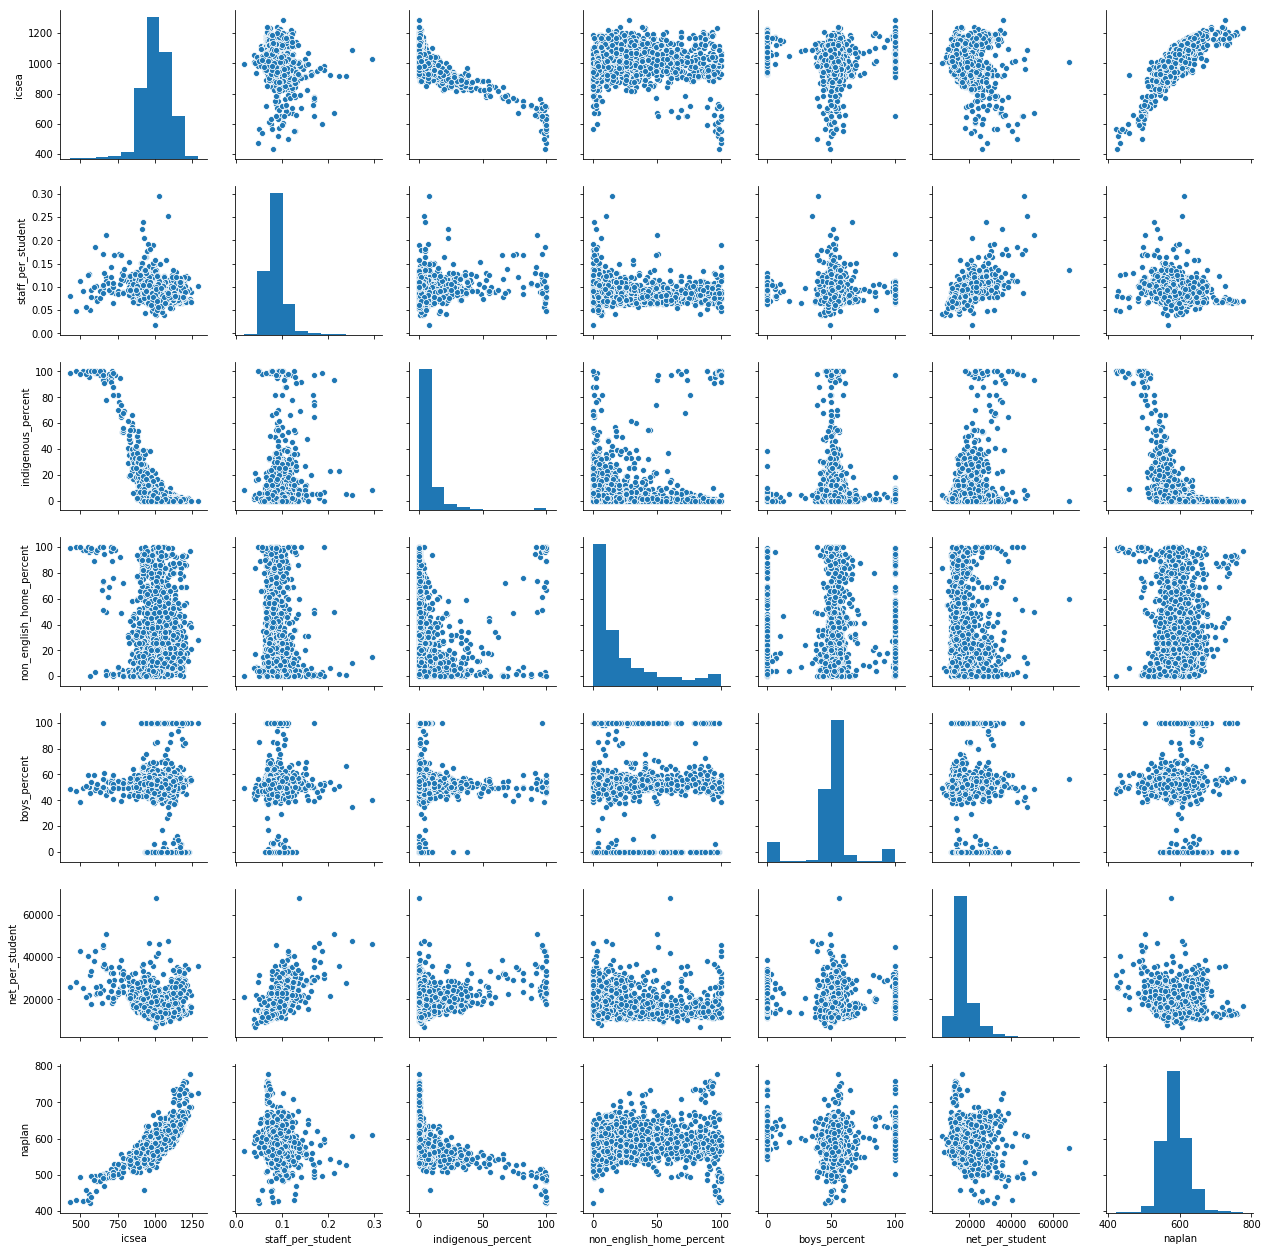

In [12]:
sns.pairplot(df[['icsea', 'staff_per_student', 'indigenous_percent', 'non_english_home_percent', 
                'boys_percent', 'net_per_student', 'naplan']])

#### Observations from pairplots:

- ICSEA and NAPLAN are highly positively correlated indicating that the higher your educational advantage, the higher your NAPLAN numeracy results will be in high school
- NAPLAN results are normally distributed, and therefore can be used to approximate a large variety of distributions in large samples.
- From the histograms, we learn that the indigenous and ESL variables are heavily right skewed which means that we have a positive skewness in distribution.
- Indigenous student percentage and NAPLAN results seem to be negatively correlated indicating that teenagers of Aboriginal/Torres Strait Islander backgrounds are not attaining the highest of scores, and might need some work to be done to improve their numeracy skills. However, this of course does not prove that one causes the other, as there may be a confounding variable that is causing this outcome.
- It appears that there are a few plots that shows no relationship between the variables. The data requires some stratification/classification in order to be interpreted easily and possibly show some relationship between them. A relationship may not be apparent at times due to the data not covering a wide enough range (i.e. binning)

## Categorical Features

Our categorical features are plotted below:

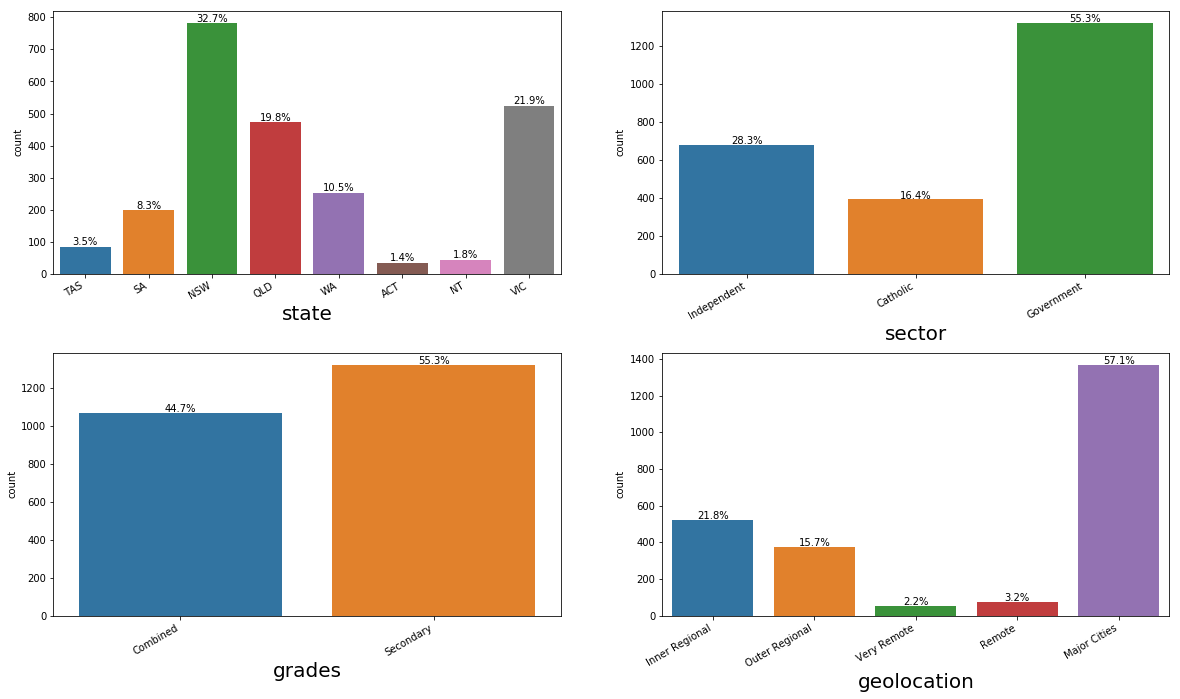

In [13]:
#plotting sourced from https://www.kaggle.com/gemunu/student-perfomance

fig = plt.figure(figsize=(20, 30))
fig.subplots_adjust(hspace=.3, wspace=0.2)

for i in range(1,len(categorical_features)+1,1):
    ax = fig.add_subplot(5, 2, i,)
    sns.countplot(df[categorical_features[i-1]])
    ax.xaxis.label.set_size(20)
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
    total = float(len(df))
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,height + 5,'{:1.1f}%'.format(100 * height/total),ha="center")

#### Observations from count plots:

- NSW has the most high schools (32.7%) followed by VIC (21.9%). ACT only has 1.4%.
- The majority of schools are Government schools (55.3%) while the remaining 44.7% of schools are either Independant (28.3%) or Catholic (16.4%)
- The majority of schools are in Major Cities.

### Factors affecting NAPLAN results
Below are various school categories (Sector, State and Geolocation) and their impact on NAPLAN results

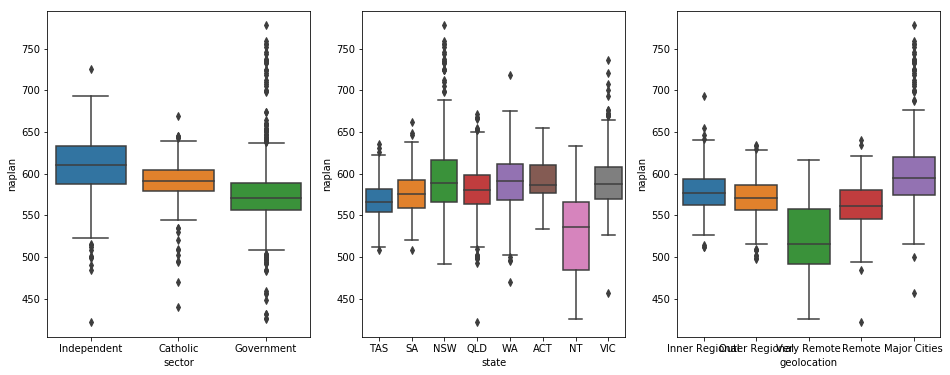

In [14]:
f, axes = plt.subplots(1, 3, figsize=(16,6))
sns.boxplot(x='sector', y='naplan', data=df, orient='v' , ax=axes[0])
sns.boxplot(x='state', y='naplan', data=df,  orient='v' , ax=axes[1])
sns.boxplot(x='geolocation', y='naplan', data=df,  orient='v' , ax=axes[2])

Observing the boxplots above, we can see that the **SECTOR** your school belongs to has a definite impact on Numeracy NAPLAN results. If we focus on the medians, Independant has a median of ~610, Catholic of ~590 and Government of ~ 560. There are a few Government schools that are outliers and have the highest NAPLAN results in the country but on avergae, Government schools perform worse than the other sectors. 

There are a lot of differences in NAPLAN scores between **States**.We can see the NSW achieves the highest Numeracy NAPLAN scores (based on median) followed by WA and VIC. NT achieves the lowest scores on average. 

There are also vast differences between **Geolocations**. Major cities do a lot better than all the other geolocations. Very Remote regions achieve the lowest Numercay NAPLAN scores on average. 

## Baseline Model: Linear Model

For our first model, we'll run a linear regression on all the continuous data. We will use a test size of 30% to check our predictions. 

In [15]:
numerical_features = ['icsea','staff','numStudents','staff_per_student','indigenous_percent',
                    'non_english_home_percent','boys_percent','Aus_funding','state_funding',
                    'parent_funding','other_funding','gross_funding','gross_per_student',
                     'net_per_student']

In [16]:
y = df['naplan']
X = df[numerical_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

baseline_model = LinearRegression()
baseline_model.fit(X_train,y_train)

yhat=baseline_model.predict(X_test)

from sklearn.metrics import r2_score, mean_squared_error
print("RMSE: {:.2f}".format(np.sqrt(mean_squared_error(y_test, yhat))))
print("\nR^2: {:.3f}".format(r2_score(y_test, yhat)))

RMSE: 16.66

R^2: 0.760


For our baseline model we have achieved 76% rSquared and an RMSE 16.66 This is quite a good model for our baseline. 

Next we will add our categorical variables by first converting them to dummy variables.

In [17]:
#CONVERT CATEGORICAL TO DUMMIES

#create mini dataframes of the dummy variables
df_state = pd.get_dummies(df['state'], prefix='state')
df_sector = pd.get_dummies(df['sector'], prefix='sector')
df_geolocation = pd.get_dummies(df['geolocation'], prefix='geolocation')

#then add these back into the original dataframe. 
df = pd.concat([df, df_state], axis=1)
df = pd.concat([df, df_sector], axis=1)
df = pd.concat([df, df_geolocation], axis=1)

df.head()

,state,sector,grades,geolocation,icsea,staff,numStudents,staff_per_student,indigenous_percent,non_english_home_percent,...,state_VIC,state_WA,sector_Catholic,sector_Government,sector_Independent,geolocation_Inner Regional,geolocation_Major Cities,geolocation_Outer Regional,geolocation_Remote,geolocation_Very Remote
40001,TAS,Independent,Combined,Inner Regional,1130.0,33.3,372.0,0.089516,1.0,7.0,...,0,0,0,0,1,1,0,0,0,0
40002,TAS,Independent,Combined,Outer Regional,969.0,14.5,194.0,0.074742,8.0,4.0,...,0,0,0,0,1,0,0,1,0,0
40005,TAS,Independent,Combined,Inner Regional,1053.0,9.1,100.0,0.091000,0.0,0.0,...,0,0,0,0,1,1,0,0,0,0
40007,TAS,Independent,Combined,Inner Regional,1108.0,76.4,743.0,0.102826,2.0,7.0,...,0,0,0,0,1,1,0,0,0,0
40008,TAS,Catholic,Combined,Outer Regional,897.0,22.1,239.0,0.092469,36.0,0.0,...,0,0,1,0,0,0,0,1,0,0


## Linear Model After Converting Categoricals to Dummy Variables

In [18]:
#get a list of numerical features
numerical_features = list(df.select_dtypes(include=[np.number]).columns.values)
numerical_features.remove('naplan')

X = df.drop('naplan', axis=1)
X = X[numerical_features]
y = df['naplan']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

lmodel = LinearRegression()
lmodel.fit(X_train,y_train)

#print("y = ", baseline_model.intercept_, " + X*", baseline_model.coef_)
yhat=lmodel.predict(X_test)

from sklearn.metrics import r2_score, mean_squared_error
print("RMSE: {:.2f}".format(np.sqrt(mean_squared_error(y_test, yhat))))#predicted))
print("\nR^2: {:.3f}".format(r2_score(y_test, yhat)))#predicted))

RMSE: 15.48

R^2: 0.793


Our model with ALL our features in it has an RMSE of 15.48 and a rSquared of 0.793. The addition of our dummy variables has increased our rSquared by 3% and has slightly reduced our RMSE. Next we will use Recursive Feature Elimination Cross Validation to decide on the optimal number of features.

## Recursive Feature Elimination

In [24]:
rfecv = RFECV(estimator=lmodel, cv=3)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Fit recursive feature eliminator 
rfecv.fit(X, y)

# Number of best features
print("After running the RFECV, there are ",rfecv.n_features_," selected features. We started with ", len(numerical_features))

After running the RFECV, there are  29  selected features. We started with  30


It seems that 29 features (out of 30) are deemed important by the RFECV. Below is a plot showing how the number of features was chosen. 

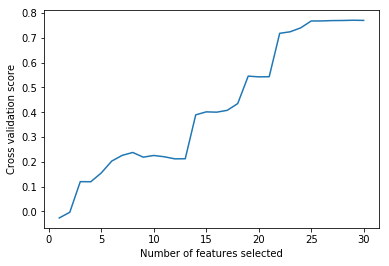

In [26]:
# Plot number of features VS. cross-validation scores
#Source: http://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Lets find out which features needs to be eliminated. Below we will put all the features and their ranking in a dataframe. Since the 29 selected features will have a ranking of 1, lets display the features with a ranking >1

In [26]:
#create empty DateFrame to store rankings
rankdf=pd.DataFrame(index=numerical_features)

#add ranking array to dataframe (by converting to a series)
rankdf['ranking']=pd.Series(rfecv.ranking_, rankdf.index)

#sort values in ascending order
rankdf.sort_values(by='ranking', ascending=True, inplace=True)
rankdf[rankdf.ranking>1]

,ranking
gross_per_student,2


The feature `gross_per_student` needs to be removed from our model. 

In [27]:
#X.drop('numStudents', axis=1, inplace=True)
X.drop('gross_per_student', axis=1, inplace=True)

## Run LinearRegression again with the optimal Number of features as per RFE

In order to optimise our model, we have removed the feature `gross_per_student`. This should see an improvement in our model. 

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

from sklearn.linear_model import LinearRegression
lmodel = LinearRegression()
lmodel.fit(X_train,y_train)

yhat=lmodel.predict(X_test)

from sklearn.metrics import r2_score, mean_squared_error
print("RMSE: {:.2f}".format(np.sqrt(mean_squared_error(y_test, yhat))))
print("\nR^2: {:.3f}".format(r2_score(y_test, yhat)))

RMSE: 15.46

R^2: 0.794


Our model has been improved.

Our final linear model after including cateogircal dummy variables and running RFE has resulted in an rSquared of 0.794 i.e. our model explains 79.4% of the variation in our data. And our RMSE is 15.46 which, considering our class label is on a scale of 0-1000, this is a relatively small RMSE. 

Below are the coefficients of our model.

In [30]:
print("y = ", lmodel.intercept_, " + \n    X*", lmodel.coef_)
print("\n",X.columns.values)

y =  123.2343005057752  + 
    X* [ 4.37102349e-01 -2.87745319e-01  1.29825485e-02  7.88461062e+01
  5.43362576e-01  3.03473787e-01  6.06236801e-02 -4.60060191e-01
 -4.60060659e-01 -4.60060651e-01 -4.60059231e-01  4.60061133e-01
 -1.05899469e-04 -1.45536721e+01  1.03975518e+01 -1.40973889e+01
  3.48551323e+00 -1.80994428e+00  1.89499127e+00  5.46451972e+00
  9.21842925e+00 -5.21432590e+00  7.59621262e+00 -2.38188672e+00
 -5.39822694e-02 -8.51958604e+00  4.86720715e+00  5.73407282e+00
 -2.02771166e+00]

 ['icsea' 'staff' 'numStudents' 'staff_per_student' 'indigenous_percent'
 'non_english_home_percent' 'boys_percent' 'Aus_funding' 'state_funding'
 'parent_funding' 'other_funding' 'gross_funding' 'net_per_student'
 'state_ACT' 'state_NSW' 'state_NT' 'state_QLD' 'state_SA' 'state_TAS'
 'state_VIC' 'state_WA' 'sector_Catholic' 'sector_Government'
 'sector_Independent' 'geolocation_Inner Regional'
 'geolocation_Major Cities' 'geolocation_Outer Regional'
 'geolocation_Remote' 'geolocation_Ve

## The most important features as per RFE

We ran RFE with our remaining 29 variables and selected `n_features_to_select=1` so that we could then obtain the `ranking_` to list them in order of importance. The results are below

In [29]:
from sklearn.feature_selection import RFE

#run the RFE until only 1 feature is left
rfe = RFE(LinearRegression(),n_features_to_select=1)
rfe.fit(X_train, y_train)

#create empty DateFrame to store rankings
rankdf=pd.DataFrame(index=list(X.columns.values))

#add ranking array to dataframe (by converting to a series)
rankdf['ranking']=pd.Series(rfe.ranking_, rankdf.index)

#sort values in ascending order
rankdf.sort_values(by='ranking', ascending=True, inplace=True)
rankdf

,ranking
sector_Independent,1
sector_Catholic,2
sector_Government,3
state_NT,4
state_TAS,5
state_SA,6
state_QLD,7
state_ACT,8
state_WA,9
state_VIC,10


Interestingly, there is a patern with the order of importance. There is some grouping among the importance with all the SECTOR types being the most important feature. 

This is followed by all the STATES, then the GEOLOCATIONS.

We have been able to determine that your school's SECTOR, STATE and GEOLOCATION are the most influential factors in Year 9 Numeracy NAPLAN scores. This is followed by a school's ICSEA

## Naive Bayes Classifier

#### Initial Data Exploration

- Here we display the first few entries in our dataframe before performing any transformations on the data.
- We separate the numerical and categorical variables to for binning and discretization respectively.

In [34]:
df2.head()

,state,sector,grades,geolocation,icsea,staff,numStudents,staff_per_student,indigenous_percent,non_english_home_percent,boys_percent,Aus_funding,state_funding,parent_funding,other_funding,gross_funding,gross_per_student,net_per_student,naplan
40001,TAS,Independent,Combined,Inner Regional,1130.0,33.3,372.0,0.089516,1.0,7.0,0.000000,2045885.0,652459.0,4459893.0,196090.0,7354327.0,19877.0,18056.0,614.0
40002,TAS,Independent,Combined,Outer Regional,969.0,14.5,194.0,0.074742,8.0,4.0,59.793814,1891542.0,572070.0,357110.0,41357.0,2862079.0,15918.0,14189.0,565.0
40005,TAS,Independent,Combined,Inner Regional,1053.0,9.1,100.0,0.091000,0.0,0.0,54.000000,883228.0,169504.0,311991.0,29318.0,1394041.0,12968.0,12968.0,631.0
40007,TAS,Independent,Combined,Inner Regional,1108.0,76.4,743.0,0.102826,2.0,7.0,51.816958,5637449.0,1803270.0,9162105.0,496490.0,17099314.0,23716.0,20725.0,605.0
40008,TAS,Catholic,Combined,Outer Regional,897.0,22.1,239.0,0.092469,36.0,0.0,56.903766,3112308.0,782272.0,371979.0,60463.0,4327022.0,19231.0,17451.0,559.0


In [35]:
nums = list(df2.select_dtypes(include=[np.number]).columns.values)
print("Numerical variables: \n", nums, "\n")

cats = list(df2.select_dtypes(include='object').columns.values)
print("Categorical variables: \n", cats)

Numerical variables: 
 ['icsea', 'staff', 'numStudents', 'staff_per_student', 'indigenous_percent', 'non_english_home_percent', 'boys_percent', 'Aus_funding', 'state_funding', 'parent_funding', 'other_funding', 'gross_funding', 'gross_per_student', 'net_per_student', 'naplan'] 

Categorical variables: 
 ['state', 'sector', 'grades', 'geolocation']


## Gaussian Naive Bayes

We used GaussianNB to classify our data according to bands by transforming the continuous numerical variables into categorized bins (bands). The pandas cut function to bin the numerical variables into encoded categorical labels (5-10). Before applying the model, GaussianNB assumes that the continuous values in the dataset follow a normal distribution. This plot is displayed below to check our "naplan" class label distribution.

When attribute values are continuous, an assumption is made that the values associated with each class are distributed according to Gaussian Normal Distribution. If in our data, an attribute contains continuous data, we segment said data by the class and then compute the accuracy score of the model.

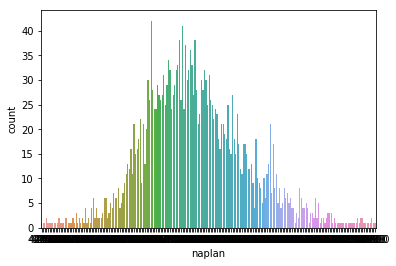

In [36]:
sns.countplot("naplan", data=df2)

### Bin numerical variables

#### <span style="color:red">**Categorise results into bins where bands 5-10 are as per NAPLAN results**:</span>
    - Students are above the national minimum standard:
        - Band 10: 687-778
        - Band 9: 635-686
        - Band 8: 583-634
        - Band 7: 531-582 
    - Students are at the national minimum standard:
        - Band 6: 479-530
    - Students are below the national minimum standard:
        - Band 5: 421-478

In [37]:
# Specify bin ranges
bin = [421, 478, 530, 582, 634, 686, 778]
bin_names = [5,6,7,8,9,10]

# Segment data values into bins and transform them into discrete intervals
category = pd.cut(df2.naplan, bin, right=True, labels=bin_names)
category = category.to_frame()
category.columns = ['band']

# Aggregate updated column into new dataframe
df2 = pd.concat([df2,category],axis=1)
df2.head()

,state,sector,grades,geolocation,icsea,staff,numStudents,staff_per_student,indigenous_percent,non_english_home_percent,boys_percent,Aus_funding,state_funding,parent_funding,other_funding,gross_funding,gross_per_student,net_per_student,naplan,band
40001,TAS,Independent,Combined,Inner Regional,1130.0,33.3,372.0,0.089516,1.0,7.0,0.000000,2045885.0,652459.0,4459893.0,196090.0,7354327.0,19877.0,18056.0,614.0,8
40002,TAS,Independent,Combined,Outer Regional,969.0,14.5,194.0,0.074742,8.0,4.0,59.793814,1891542.0,572070.0,357110.0,41357.0,2862079.0,15918.0,14189.0,565.0,7
40005,TAS,Independent,Combined,Inner Regional,1053.0,9.1,100.0,0.091000,0.0,0.0,54.000000,883228.0,169504.0,311991.0,29318.0,1394041.0,12968.0,12968.0,631.0,8
40007,TAS,Independent,Combined,Inner Regional,1108.0,76.4,743.0,0.102826,2.0,7.0,51.816958,5637449.0,1803270.0,9162105.0,496490.0,17099314.0,23716.0,20725.0,605.0,8
40008,TAS,Catholic,Combined,Outer Regional,897.0,22.1,239.0,0.092469,36.0,0.0,56.903766,3112308.0,782272.0,371979.0,60463.0,4327022.0,19231.0,17451.0,559.0,7


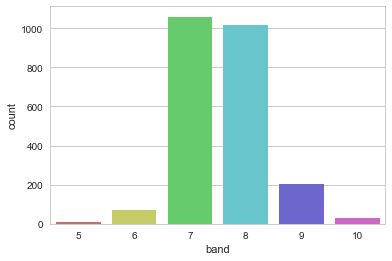

In [38]:
# Create histogram plot
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
sns.countplot(x = 'band', data = df2, palette = 'hls')
plt.show()

In [39]:
# Instantiate data and target features and store numerical and categorical variables respectively
cat_data = ['state', 'sector', 'geolocation', 'grades']
num_data = ['icsea', 'staff', 'numStudents', 'staff_per_student', 'indigenous_percent',
               'non_english_home_percent', 'Aus_funding', 'state_funding', 'parent_funding', 'other_funding',
               'gross_funding', 'gross_per_student', 'net_per_student']
target = df2['band']

In [40]:
# Store the feature matrix (X or data) and response vector (y or target) 
X = df2[num_data]
y = target

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
#print(X_train.shape, X_test.shape)

# Train the model on training set
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Predict using test set
y_pred = gnb.predict(X_test)

# Calculate the accuracy by comparing actual response with predicted response
from sklearn.metrics import accuracy_score
print("Accuracy: {:.6f} ({:05.2f}%)".format(gnb.score(X_test, y_test),
                                            (100*(1-(y_test != y_pred).sum()/X_test.shape[0]))))
print("Number of mislabeled points out of a total {} points : {}".format(X_test.shape[0],
                                                                                (y_test != y_pred).sum()))

Accuracy: 0.586351 (58.64%)
Number of mislabeled points out of a total 718 points : 297


(0, 1340.6507932075772)

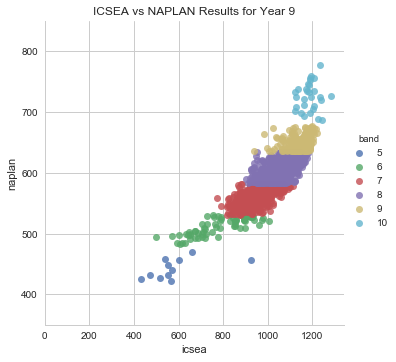

In [41]:
sns.lmplot(x='icsea', y='naplan', data=df2, fit_reg=False, hue="band", size=5)
plt.title("ICSEA vs NAPLAN Results for Year 9")
plt.ylim(350, 850)
plt.xlim(0, None)

In [56]:
# Specify the graph parameters
fig = plt.figure(figsize=(18,6), dpi=1600) 
alpha=alpha_scatterplot = 0.2 
alpha_bar_chart = 0.55

# Plot a bar graph of categorical bands  
ax1 = plt.subplot2grid((2,3),(0,0))          
df2.band.value_counts().plot(kind='bar', alpha=alpha_bar_chart)
ax1.set_xlim(-1, 6)
plt.title("Distribution of NAPLAN result as band")

# Plot a bar graph showing sector distribution
ax2 = plt.subplot2grid((2,3), (0,1))
df.sector.value_counts().plot(kind="barh", alpha=alpha_bar_chart)
ax2.set_ylim(-1, len(df.sector.value_counts()))
plt.title("Sector distribution")

ax3 = plt.subplot2grid((2,3),(1,0))#, colspan=2)
# plots a kernel density estimate of the subset of the 1st class passangers's age
df2.icsea[df2.band == 5].plot(kind='kde')    
df2.icsea[df2.band == 6].plot(kind='kde')
df2.icsea[df2.band == 7].plot(kind='kde')
df2.icsea[df2.band == 8].plot(kind='kde')    
df2.icsea[df2.band == 9].plot(kind='kde')
df2.icsea[df2.band == 10].plot(kind='kde')
# plots an axis lable
plt.xlabel("ICSEA")    
plt.title("ICSEA Distribution within classes 'naplan'")
# sets our legend for our graph.
plt.legend(('Band 5', 'Band 6', 'Band 7', 'Band 8', 'Band 9', 'Band 10'), loc='best')

#### <span style="color:green">Observations</span>

- The accuracy score suggests that 55% of the points are being correctly labelled by the GaussianNB classifier using the test set, thus having a relatively fair performance as a means of classifying this data set.

## Multinomial Naive Bayes

We then used MultinomialNB to classify our data by transforming the discrete categorical variables into numerical features. After training on a normal MNB model, we furthered our approach by using KBinsDiscretizer to classify the encoded categorical data into respective bins, and the results were re-fitted into the MNB model. We also decided to further improve the MNB model by using RFE in hopes of attaining a better accuracy score.

### Multi-Column Label Encoder

In [45]:
# Source: https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [46]:
df2 = MultiColumnLabelEncoder(columns = ['state', 'sector', 'grades', 'geolocation']).fit_transform(df2)
df2.head()

,state,sector,grades,geolocation,icsea,staff,numStudents,staff_per_student,indigenous_percent,non_english_home_percent,boys_percent,Aus_funding,state_funding,parent_funding,other_funding,gross_funding,gross_per_student,net_per_student,naplan,band
40001,5,2,0,0,1130.0,33.3,372.0,0.089516,1.0,7.0,0.000000,2045885.0,652459.0,4459893.0,196090.0,7354327.0,19877.0,18056.0,614.0,8
40002,5,2,0,2,969.0,14.5,194.0,0.074742,8.0,4.0,59.793814,1891542.0,572070.0,357110.0,41357.0,2862079.0,15918.0,14189.0,565.0,7
40005,5,2,0,0,1053.0,9.1,100.0,0.091000,0.0,0.0,54.000000,883228.0,169504.0,311991.0,29318.0,1394041.0,12968.0,12968.0,631.0,8
40007,5,2,0,0,1108.0,76.4,743.0,0.102826,2.0,7.0,51.816958,5637449.0,1803270.0,9162105.0,496490.0,17099314.0,23716.0,20725.0,605.0,8
40008,5,0,0,2,897.0,22.1,239.0,0.092469,36.0,0.0,56.903766,3112308.0,782272.0,371979.0,60463.0,4327022.0,19231.0,17451.0,559.0,7


In [47]:
# Store the feature matrix (X) and response vector (y) 
X = df2[cat_data]
y = target

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# Train the model on training set
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [48]:
# Predict using test set
y_pred = mnb.predict(X_test)

# Calculate the accuracy by comparing actual response with predicted response
from sklearn.metrics import accuracy_score
print("Accuracy: {:.6f} ({:05.2f}%)".format(mnb.score(X_test, y_test),
                                            (100*(1-(y_test != y_pred).sum()/X_test.shape[0]))))
print("Number of mislabeled points out of a total {} points : {}".format(X_test.shape[0],
                                                                                (y_test != y_pred).sum()))

Accuracy: 0.509749 (50.97%)
Number of mislabeled points out of a total 718 points : 352


#### <span style="color:green">Observations:</span>

- The accuracy score suggests that 50% of the points are being correctly labelled by the MultinomialNB classifier using the test set, thus having a relatively fair performance as a means of classifying this data set.
- This test performed less than the Gaussian model, and thus we attempted to attain a better accuracy rate through discretization and recursive feature elimination.

### Discretization (KBinsDiscretizer)

In [49]:
# Instantiate and fit numerical data to discretizer (into bins)
enc = KBinsDiscretizer(n_bins=4, encode='ordinal').fit(df2[num_data])
df_binned = enc.fit_transform(df2[num_data])

# Create new dataframe that stores the binned data (converted from continuous to discrete)
discr_df = pd.DataFrame(df_binned, columns = df2[num_data].columns)

# Combine new binned dataframe with the categorical data
combined_df = pd.concat([discr_df, df2[cat_data]], axis=1)
combined_df.shape

# Original dataframe with numerical features converted to discrete variables
discr_df.head()

,icsea,staff,numStudents,staff_per_student,indigenous_percent,non_english_home_percent,Aus_funding,state_funding,parent_funding,other_funding,gross_funding,gross_per_student,net_per_student
0,3.0,0.0,0.0,2.0,1.0,1.0,1.0,0.0,3.0,1.0,1.0,3.0,2.0
1,1.0,0.0,0.0,1.0,3.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
2,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,3.0,2.0,2.0,3.0,1.0,1.0,3.0,0.0,3.0,2.0,3.0,3.0,3.0
4,0.0,0.0,0.0,3.0,3.0,0.0,2.0,0.0,1.0,0.0,0.0,2.0,2.0


### MultinomialNB for Discretized Data

- Re-run MultinomialNB using discretized data

In [50]:
# Store the feature matrix (X) and response vector (y) 
X = discr_df
y = target

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# Train the model on training set
dmnb = MultinomialNB()
dmnb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [51]:
# Predict using test set
y_pred = dmnb.predict(X_test)

# Calculate the accuracy by comparing actual response with predicted response
from sklearn.metrics import accuracy_score
print("Accuracy: {:.6f} ({:05.2f}%)".format(dmnb.score(X_test, y_test),
                                            (100*(1-(y_test != y_pred).sum()/X_test.shape[0]))))
print("Number of mislabeled points out of a total {} points : {}".format(X_test.shape[0],
                                                                                (y_test != y_pred).sum()))

Accuracy: 0.615599 (61.56%)
Number of mislabeled points out of a total 718 points : 276


#### <span style="color:green">Observations:</span>

- The accuracy score suggests that 60% of the points are being correctly labelled by the MultinomialNB classifier (after discrtization) using the test set, thus having a slightly improved performance from previous attempts on models.
- This test performed slightly better than the Gaussian and Multinomial model

### Recursive Feature Elimination (RFE)
- Determine and select the best/most important features with RFE

In [52]:
from sklearn.feature_selection import RFECV

# Run RFECV
estimator = mnb
selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(X, y)

# Reduce dataframe to only the selected features
selected_df = X[X.columns[selector.get_support(indices=True)]]

print("Shape of reduced/transformed df:{}".format(selected_df.shape))
print("Shape of class label 'y'): {}".format(y.shape))
selected_df.head()

Shape of reduced/transformed df:(2391, 5)
Shape of class label 'y'): (2391,)


,icsea,staff,numStudents,indigenous_percent,parent_funding
0,3.0,0.0,0.0,1.0,3.0
1,1.0,0.0,0.0,3.0,1.0
2,2.0,0.0,0.0,0.0,1.0
3,3.0,2.0,2.0,1.0,3.0
4,0.0,0.0,0.0,3.0,1.0


### MultinomialNB for RFE

- Re-run MultinomialNB using selected features from RFE
- X is now reduced to 5 variables as shown in the above table

In [53]:
# Store the feature matrix (X) and response vector (y) 
X = selected_df
y = target

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# Train the model on training set
smnb = MultinomialNB()
smnb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [54]:
# Predict using test set
y_pred = smnb.predict(X_test)

# Calculate the accuracy by comparing actual response with predicted response
from sklearn.metrics import accuracy_score
print("Accuracy: {:.6f} ({:05.2f}%)".format(smnb.score(X_test, y_test), (100*(1-(y_test != y_pred).sum()/X_test.shape[0]))))
print("Number of mislabeled points out of a total {} points : {}".format(X_test.shape[0],
                                                                                (y_test != y_pred).sum()))

Accuracy: 0.703343 (70.33%)
Number of mislabeled points out of a total 718 points : 213


<span style="color:green">**Observations:**</span>

- The accuracy score suggests that 70% of the points are being correctly labelled by the GaussianNB classifier (after RFE) using the test set, thus having a overall improved performance in terms of its accuracy to predict results.
- By far, this is the best accuracy results out of all the models, although only achieving an average score of 70%.